# Preprocess

In [77]:
import pandas as pd

In [78]:
df = pd.read_csv("./US-Economic-News.csv", delimiter=',', encoding= 'ISO-8859-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               8000 non-null   int64  
 1   _golden                8000 non-null   bool   
 2   _unit_state            8000 non-null   object 
 3   _trusted_judgments     8000 non-null   int64  
 4   _last_judgment_at      8000 non-null   object 
 5   positivity             1420 non-null   float64
 6   positivity:confidence  3775 non-null   float64
 7   relevance              8000 non-null   object 
 8   relevance:confidence   8000 non-null   float64
 9   articleid              8000 non-null   object 
 10  date                   8000 non-null   object 
 11  headline               8000 non-null   object 
 12  positivity_gold        0 non-null      float64
 13  relevance_gold         0 non-null      float64
 14  text                   8000 non-null   object 
dtypes: b

In [79]:
df.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [80]:
df = df[['headline', 'text', 'relevance']]

# We drop all irrelavant features to only keep headline and text for 2 reasons: 
# The other features seem either irrelevant or we lack documentation
# With headline and text only, our final model will be more generalizable. We could in theory apply it to any article.

In [81]:
import numpy as np

df_yes = df[df['relevance'] == 'yes']
df_no = df[df['relevance'] == 'no']

df_no_sampled = df_no.sample(n=len(df_yes), random_state=42)

# Concatenate the sampled 'no' rows with all 'yes' rows
df_balanced = pd.concat([df_yes, df_no_sampled])

print(df_balanced['relevance'].value_counts())

relevance
yes    1420
no     1420
Name: count, dtype: int64


In [82]:
df = df_balanced

Cleaning Strings

In [83]:
#!pip install nltk

In [84]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [85]:
# #Ensure you have downloaded the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/alirammal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alirammal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alirammal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [86]:
df['whole_txt'] = df['headline']+ ' ' + df['text']

In [87]:
def preprocess_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\W', ' ', text)  # remove all non-word characters
    text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with a single space
    return text

df['processed'] = df['whole_txt'].apply(preprocess_text)


In [88]:
df['processed'].head()

0     yields on cds fell in the latest week new york...
4     currency trading dollar remains in tight range...
5     stocks fall again bofa alcoa slide stocks decl...
9     u s dollar falls against most currencies decli...
12    defending yourself against deflation author ja...
Name: processed, dtype: object

In [89]:
 # Tokenize before word2vec
df['tokenized'] = df['processed'].apply(lambda x: x.split())

In [90]:
total_words = len(df['tokenized']) + 1

In [91]:
# Train word2vec model with tokenized features
from gensim.models import Word2Vec
sentences = df['tokenized'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [92]:
import numpy as np

def vectorize_text(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

df['vectorized'] = df['tokenized'].apply(lambda x: vectorize_text(x, word2vec_model))


In [93]:
# Separate features and target
X = np.array(df['vectorized'].tolist())
y = df['relevance']  # Replace with your actual target variable

### Train-Test Split

In [39]:
df.update(df["relevance"].apply(lambda x: 0 if x == "no" else 1))

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)

In [42]:
X_train

array([[ 0.22758457,  0.36510468, -0.00475967, ..., -0.5035157 ,
        -0.33690917,  0.21705444],
       [ 0.28083134,  0.41457623,  0.09628548, ..., -0.26677087,
        -0.00115844,  0.20579   ],
       [ 0.10404396,  0.4407978 ,  0.21914813, ..., -0.32642737,
        -0.26696372,  0.01396847],
       ...,
       [ 0.14983018,  0.41611037,  0.03771764, ..., -0.46976563,
        -0.3797513 ,  0.14465275],
       [ 0.24822363,  0.32223827,  0.03768502, ..., -0.4383227 ,
        -0.20765889,  0.05493077],
       [ 0.3509504 ,  0.263665  , -0.13101527, ..., -0.472133  ,
        -0.10761338,  0.31441224]], dtype=float32)

In [43]:
X_train.shape

(1817, 100)

In [44]:
y_train

6965    1
2156    1
1103    1
7486    1
5865    1
       ..
2245    1
1956    1
3711    1
506     1
3821    1
Name: relevance, Length: 1817, dtype: object

In [45]:
y_train.shape

(1817,)

In [46]:
y_val.shape

(455,)

In [47]:
y_test.shape

(568,)

In [48]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [61]:
X_train = np.array(X_train).astype('float32')
X_val = np.array(X_val).astype('float32')
y_train = np.array(y_train).astype('float32')
y_val = np.array(y_val).astype('float32')

### Building the model

We are going to build a simple model that includes:
- `Embedding` layer with an output representation of each word as a vector of dim 16
- `LSTM` (see class slides for more detail or RNNs example notebook for more details) with an intermediate state of 100
- An output layer `Dense` that connects the output of the LSTM and creates an output of 3 positions (one per class) as output of the network

That is model nr.1 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [52]:
total_words

2841

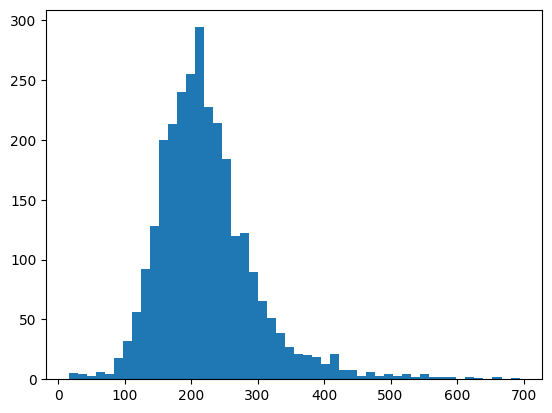

In [54]:
import matplotlib.pyplot as plt

word_counts = [len(text.split()) for text in df['whole_txt']]
plt.hist(word_counts, bins=50)
plt.show()


In [57]:
import numpy as np

max_length = int(np.percentile(word_counts, 80))  # Adjust the percentile as needed
max_length

271

In [64]:
embedding_dim = word2vec_model.vector_size
print("Word2Vec Embedding Dimension:", embedding_dim)

Word2Vec Embedding Dimension: 100


### Model 1

In [74]:
max_length = 300      # Adjust based on the length of your input sequences

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(max_length, embedding_dim)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

model.summary()

2023-12-02 18:09:52.509866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-02 18:09:52.511767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-02 18:09:52.515417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 300, 128)          117248    
                                                                 
 dropout_4 (Dropout)         (None, 300, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________


2023-12-02 18:09:52.913697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-02 18:09:52.915407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-02 18:09:52.917570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [75]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_val, y_val))

Epoch 1/10


ValueError: in user code:

    File "/Users/alirammal/opt/anaconda3/envs/aiml/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/alirammal/opt/anaconda3/envs/aiml/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alirammal/opt/anaconda3/envs/aiml/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/alirammal/opt/anaconda3/envs/aiml/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/alirammal/opt/anaconda3/envs/aiml/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/alirammal/opt/anaconda3/envs/aiml/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 300, 100), found shape=(None, 100)


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")